# Comparing different models

Tim Head, July 2016

In [1]:
from functools import partial
from itertools import cycle

import numpy as np
np.random.seed(123)

%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
plt.rcParams["figure.figsize"] = (10, 6)
plt.set_cmap("viridis")

Bayesian optimisation or sequential model-based optimisation uses a surrogate model
to model the expensive to evaluate function `func`. There are several choices
for what kind of surrogate model to use. This example compares the performance of:

* gaussian processes,
* extra trees, and
* random forests 

as surrogate models. A purely random optimisation strategy is used as a baseline.


# Toy model

We will use the `branin` function as toy model for the expensive function. In
a real world application this function would be unknown and expensive to evaluate.

In [2]:
from skopt.benchmarks import branin as _branin

def branin(x, noise_level=0.):
    return _branin(x) + np.random.randn() * noise_level

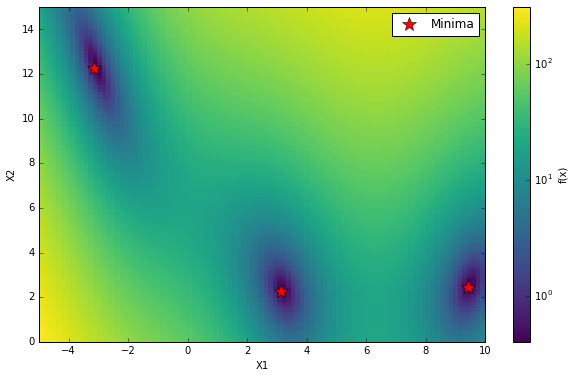

In [3]:
def plot_branin():
    fig, ax = plt.subplots()

    x1_values = np.linspace(-5, 10, 100)
    x2_values = np.linspace(0, 15, 100)
    x_ax, y_ax = np.meshgrid(x1_values, x2_values)
    vals = np.c_[x_ax.ravel(), y_ax.ravel()]
    
    fx = np.reshape([branin(val) for val in vals], (100, 100))
    
    cm = ax.pcolormesh(x_ax, y_ax, fx,
                       norm=LogNorm(vmin=fx.min(), vmax=fx.max()),
                       label='branin')

    minima = np.array(((-np.pi, 12.275), (+np.pi, 2.275), (9.42478, 2.475)))
    ax.plot(minima[:, 0], minima[:, 1], 'r*', markersize=14, lw=0, label='Minima')
    
    cb = fig.colorbar(cm)
    cb.set_label("f(x)")
    
    ax.legend(loc='best', numpoints=1)
    
    ax.set_xlabel('X1')
    ax.set_xlim([-5, 10])
    ax.set_ylabel('X2')
    ax.set_ylim([0, 15])
    
plot_branin()

This shows the value of the two dimensional branin function and the three minima.


# Objective

The objective of this example is to find one of these minima in as few iterations
as possible. One iteration is defined as one call to the branin function.

We will evaluate each model several times using a different seed for the
random number generator. Then compare the average performance of these
models. This makes the comparison more robust against models that get
"lucky".

In [4]:
from skopt import gp_minimize, forest_minimize, dummy_minimize
from skopt.learning import RandomForestRegressor, ExtraTreesRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern

bounds = [(-5, 10), (0, 15)]
noise_level = 2.
branin_ = partial(branin, noise_level=noise_level)

In [5]:
def evaluate(minimizer, n_iter=20):
    results = []
    for n in range(n_iter):
        results.append(minimizer(random_state=n).func_vals)
        
    return results

# maximum number of allowed calls to `branin`
max_iterations = 80

# Random search
dummy_res = evaluate(partial(dummy_minimize, branin_, bounds, maxiter=max_iterations))

# Random forest
rf = RandomForestRegressor(n_estimators=100, min_samples_leaf=10, random_state=9)
forest_res = evaluate(partial(forest_minimize, branin_, bounds, base_estimator=rf,
                              maxiter=max_iterations))

# Extra trees based surrogate model
et = ExtraTreesRegressor(n_estimators=100, min_samples_leaf=3, random_state=0)
et_res = evaluate(partial(forest_minimize, branin_, bounds, base_estimator=et,
                              maxiter=max_iterations))

# Gaussian processes
gp = GaussianProcessRegressor(kernel=Matern(length_scale_bounds="fixed"), 
                              alpha=noise_level**2, random_state=6)
gp_res = evaluate(partial(gp_minimize, branin_, bounds, acq="EI", base_estimator=gp,
                          maxiter=max_iterations))

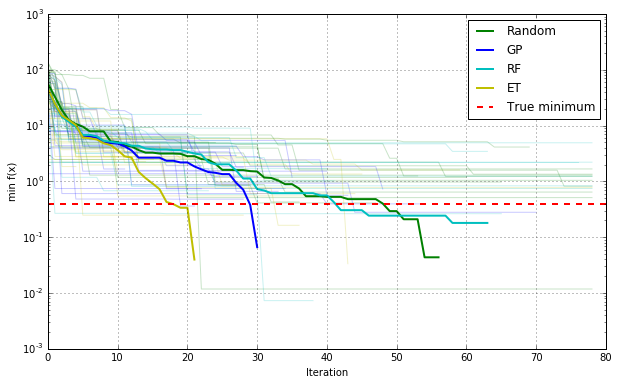

In [6]:
def plot_results(results, minimum=0.397887):
    fig, ax = plt.subplots()
    
    averages = []
    for (method, results_), color in zip(results, cycle(('g', 'b', 'c', 'y'))):
        average = np.zeros(len(results_[0]) - 1)

        for res in results_:
            best_so_far = []
            for n in range(1, len(res)):
                best_so_far.append(np.min(res[:n]))

            ax.semilogy(best_so_far, color=color, alpha=0.21)
            average += best_so_far
            
        average /= len(results_)
        averages.append((method, color, average))
        
    # draw last to make sure they are on top of everything
    for method, color, average in averages:
        ax.semilogy(average, lw=2, color=color, label=method)
    
    ax.axhline(minimum, linestyle='--', color='r', lw=2,
               label='True minimum')
    ax.set_ylabel("min f(x)")
    ax.set_xlabel("Iteration")
    ax.legend(loc='best')
    ax.grid()
    
    plt.show()
    
plot_results([('Random', dummy_res),
              ('GP', gp_res),
              ('RF', forest_res),
              ('ET', et_res)])

This plot shows the value of the minimum found (y axis) as a function of the number
of iterations performed so far (x axis). The dashed red line indicates the
true value of the minimum of the branin function.

Each minimizer only has access to noisy observations of the objective
function, so as time passes (more iterations) it will start observing values that
are below the true value simply because they are fluctuations.